# Exploring Tesser Data Using Succersor Representation  Models


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import sys
import os

In [3]:

dir_path = '/home/rodrigo/Dropbox/tesser_successor/Data/'
# path = input("Enter directory of data as string '':")

# names= pd.DataFrame(np.array(listd).reshape(len(listd),1),columns=[" Directory Names"])
# pd.set_option('display.max_colwidth', -1)
# # print(names)

def get_data(path):
    
    # simple for loop to obtain all data .txt files including subdirectories.
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if '.txt' in file:
                files.append(os.path.join(r, file))

    # list of file paths for the required data            
    listd=[]
    for f in files:
        listd.append(f)
    listd.sort()
    # list of data labels to use as keys
#     print(listd)
    
    dl=[]
    # dictionary of data sets with data labels
    data={}


    for i in range (len(listd)):
        s = listd[i]
        lb = s[44:]
        dl.append(lb)
        Test = pd.read_csv(s,sep="\t")#[' objnum']
        Test.replace([" NaN"], np.nan, inplace = True) # Drops NaN values from DataFrame
        Test = Test.dropna()
        b = Test.reset_index(drop=True) # Resets the index to start at 0
        data[lb] = b
    return data, dl

data, dl = get_data(dir_path)

# print(dl)
# data


In [4]:
# Dictionaries meant to individually extract data attributes needed

def get_objnum(num):
    
    objnum ={}# object sequence number
    trial = {}# trial number
    rt ={}# responce/reaction time
    for z in range(len(dl)):
        objnum[dl[z]]=data[dl[z]][' objnum']
        trial[dl[z]]=data[dl[z]][' trial']
        rt[dl[z]]=data[dl[z]][' rt']
        
    return objnum[dl[num]]


In [5]:

# Derived from explore_simulations.py by Demetrius Rowland
def make_envstep(direct_num):
    envstep = []
    objects = get_objnum(direct_num)
    index = 0

    for index in range ( len(objects) ):
        obj = int(objects[index])
        try:
            envstep.append (obj)
        except:
            pass
    return envstep

In [6]:

'''
 SR_no_action reduced version
'''
reward = 1 # for our purposes we will keep the reward parameter constant

class SR_Matrix():

	def __init__(self, gamma, alpha, p_sample, NUM_STATES):
		self.gamma = gamma # discount factor
		self.alpha = alpha # learning rate
		self.p_sample = p_sample # p(sampling options)		
		self.M= np.zeros([NUM_STATES, NUM_STATES]) # M: state-state SR    	
		self.onehot=np.eye(NUM_STATES) # onehot matrix, for updating M
		
	def step(self, s, s_new):

		self.update_SR(s, s_new)
        


	def update_SR(self, s, s_new):
		self.M[s] = (1-self.alpha)* self.M[s] + self.alpha * ( self.onehot[s] + self.gamma * self.M[s_new]  )
		
	

In [8]:

def SRclass_nathum_exp1(envstep, gamma, alpha, p_sample=None):


#     if p_sample==None:
#         p_sample= [.5,.5]
        
    num_states = 21

    SR_agent = SR_Matrix(gamma, alpha, p_sample, num_states)
    s = envstep[0]-1
    
    for entry in envstep[1:]: # go through trajectory till the end
            
        s_new = entry-1
        SR_agent.step (s, s_new)
            
        s = s_new


    return SR_agent.M



In [9]:
def make_plots(dir):
    
    envsteps= make_envstep(dir)
    part = dl[dir][-11]
    run = dl[dir][-5]
    M  = SRclass_nathum_exp1(envsteps, 0.5, 0.5,[0.5,0.5]) #W, mem, total_episodes

    return M

In [10]:
def i_subj_run(num):
    count = []
    for i in range(0, len(dl), 11):
        count.append(i)
        
    return count[num]

In [11]:

def func(subj_num):
    
    figsize=(70,30)
    size = 50
    a = i_subj_run(subj_num)
    fig, axs = plt.subplots(2, 6, figsize=figsize ,sharex='col', sharey='row')
    plt.suptitle(dl[a][:17]  + "  Subject " + dl[a][11:14] + "\n", size = 80)
    plt.subplots_adjust(hspace=0.5)
    title_1 = " Part_" + str(1)#dl[a][:17] + " Part_" + str(1)
    title_2 = " Part_" + str(2)#dl[a][:17] + " Part_" + str(2)
    
    for part in [1,2]:
        for run in range(0,4+part):
            if part == 1:

                axs[part-1, run].matshow(make_plots(a + run))
                axs[part-1, run].set_title(title_1 + " Run_" + dl[a + run][-5] + "\n", size=size)
            if part == 2:
                axs[part-1, run].matshow(make_plots(a + 5 + run))
                axs[part-1, run].set_title(title_2 + " Run_" + dl[a + 5 + run][-5] + "\n", size=size)
    return plt.show()

In [12]:
gamma = alpha = .5

def main (option, subj_num):
    
    figsize=(70,30)
    size = 50
    a = i_subj_run(subj_num)
    fig, axs = plt.subplots(2, 6, figsize=figsize ,sharex='col', sharey='row')
#     plt.suptitle(dl[a][:17]  + "  Subject " + dl[a][11:14] + "\n", size = 80)
    plt.subplots_adjust(hspace=0.5)
    title_1 = " Part_" + str(1)#dl[a][:17] + " Part_" + str(1)
    title_2 = " Part_" + str(2)#dl[a][:17] + " Part_" + str(2)
    
    # This option allows the SR matrix to persist across all runs from Part 1 and Part 2
    #     without ever resetting.
    if option == 'persist':
        plt.suptitle("Persistent Learning: " + dl[a][:17]  + "  Subject " + dl[a][11:14] + "\n", size = 80)
        M = np.zeros([21,21])
        for part in [1,2]:
            for run in range(0,4+part):
                if part == 1:
                    M =make_plots(a + run)
                    axs[part-1, run].matshow(M)
                    axs[part-1, run].set_title(title_1 + " Run_" + dl[a + run][-5] + "\n", size=size)
                if part == 2:
                    M = make_plots(a + 5 + run)
                    axs[part-1, run].matshow(M)
                    axs[part-1, run].set_title(title_2 + " Run_" + dl[a + 5 + run][-5] + "\n", size=size)
        return plt.show()


            
    # This option allows the SR matrix to persist in Part 1 and Part 2, but resets it between them.
    if option == 'reset':
        plt.suptitle("Reset Learning: " + dl[a][:17]  + "  Subject " + dl[a][11:14] + "\n", size = 80)
        M = np.zeros ([21,21])
        is_reset = False
        for part in [1,2]:
            for run in range(0,4+part):
                if not is_reset and part == 2:
                    M = np.zeros ([21,21])
                    is_reset = True
                if part == 1:
                    M = make_plots(a + run)
                    axs[part-1, run].matshow(M)
                    axs[part-1, run].set_title(title_1 + " Run_" + dl[a + run][-5] + "\n", size=size)
                if part == 2:

                    M = make_plots(a + 5 + run)
                    axs[part-1, run].matshow(M)
                    axs[part-1, run].set_title(title_2 + " Run_" + dl[a + 5 + run][-5] + "\n", size=size)

        return plt.show()
    
    # This option resets the SR matrix between each run.
    if option == 'independent':
        plt.suptitle("Independent Learning: " + dl[a][:17]  + "  Subject " + dl[a][11:14] + "\n", size = 80)
        for part in [1,2]:
            for run in range(0,4+part):
                if part == 1:
                    M = make_plots(a + run)
                    axs[part-1, run].matshow(M)
                    axs[part-1, run].set_title(title_1 + " Run_" + dl[a + run][-5] + "\n", size=size)
                if part == 2:
                    M = make_plots(a + 5 + run)
                    axs[part-1, run].matshow(M)
                    axs[part-1, run].set_title(title_2 + " Run_" + dl[a + 5 + run][-5] + "\n", size=size)
        return plt.show()

    # This option forces the SR matrix to persist across all runs, but instead of plotting the SR matrix
    #     after each run, it plots the changes made to it after learning each object sequence.
    if option == 'track changes':
        plt.suptitle("Learning w/ Changes: " + dl[a][:17]  + "  Subject " + dl[a][11:14] + "\n", size = 80)
        M = np.zeros([21,21])
        for part in [1,2]:
            for run in range(0,4+part):
                if part == 1:
                    envsteps = make_envstep(a + run)
                    M_new = np.copy(M)
                    M_new = SRclass_nathum_exp1(envsteps, gamma, alpha, M_new)
                    axs[part-1, run].matshow(M_new-M)
                    axs[part-1, run].set_title(title_1 + " Run_" + dl[a + run][-5] + "\n", size=size)
                    M = M_new
                if part == 2:
                    envsteps = make_envstep(a + 5 + run)
                    M_new = np.copy(M)
                    M_new = SRclass_nathum_exp1(envsteps, gamma, alpha, M_new)
                    axs[part-1, run].matshow(M_new-M)
                    axs[part-1, run].set_title(title_2 + " Run_" + dl[a + 5 + run][-5] + "\n", size=size)
                    M = M_new
        return plt.show()

In [13]:

# def cluster():
#     for i in range(0, len(dl)//11):
# #         func(i)
#         main('persist', i)
# #         main('reset', i)
#         main('independent', i)
#         main('track changes', i)
# cluster()

In [14]:

def indiv(subject_number):
    i = subject_number
    main('persist', i)
    main('reset', i)
    main('independent', i)
    main('track changes', i)


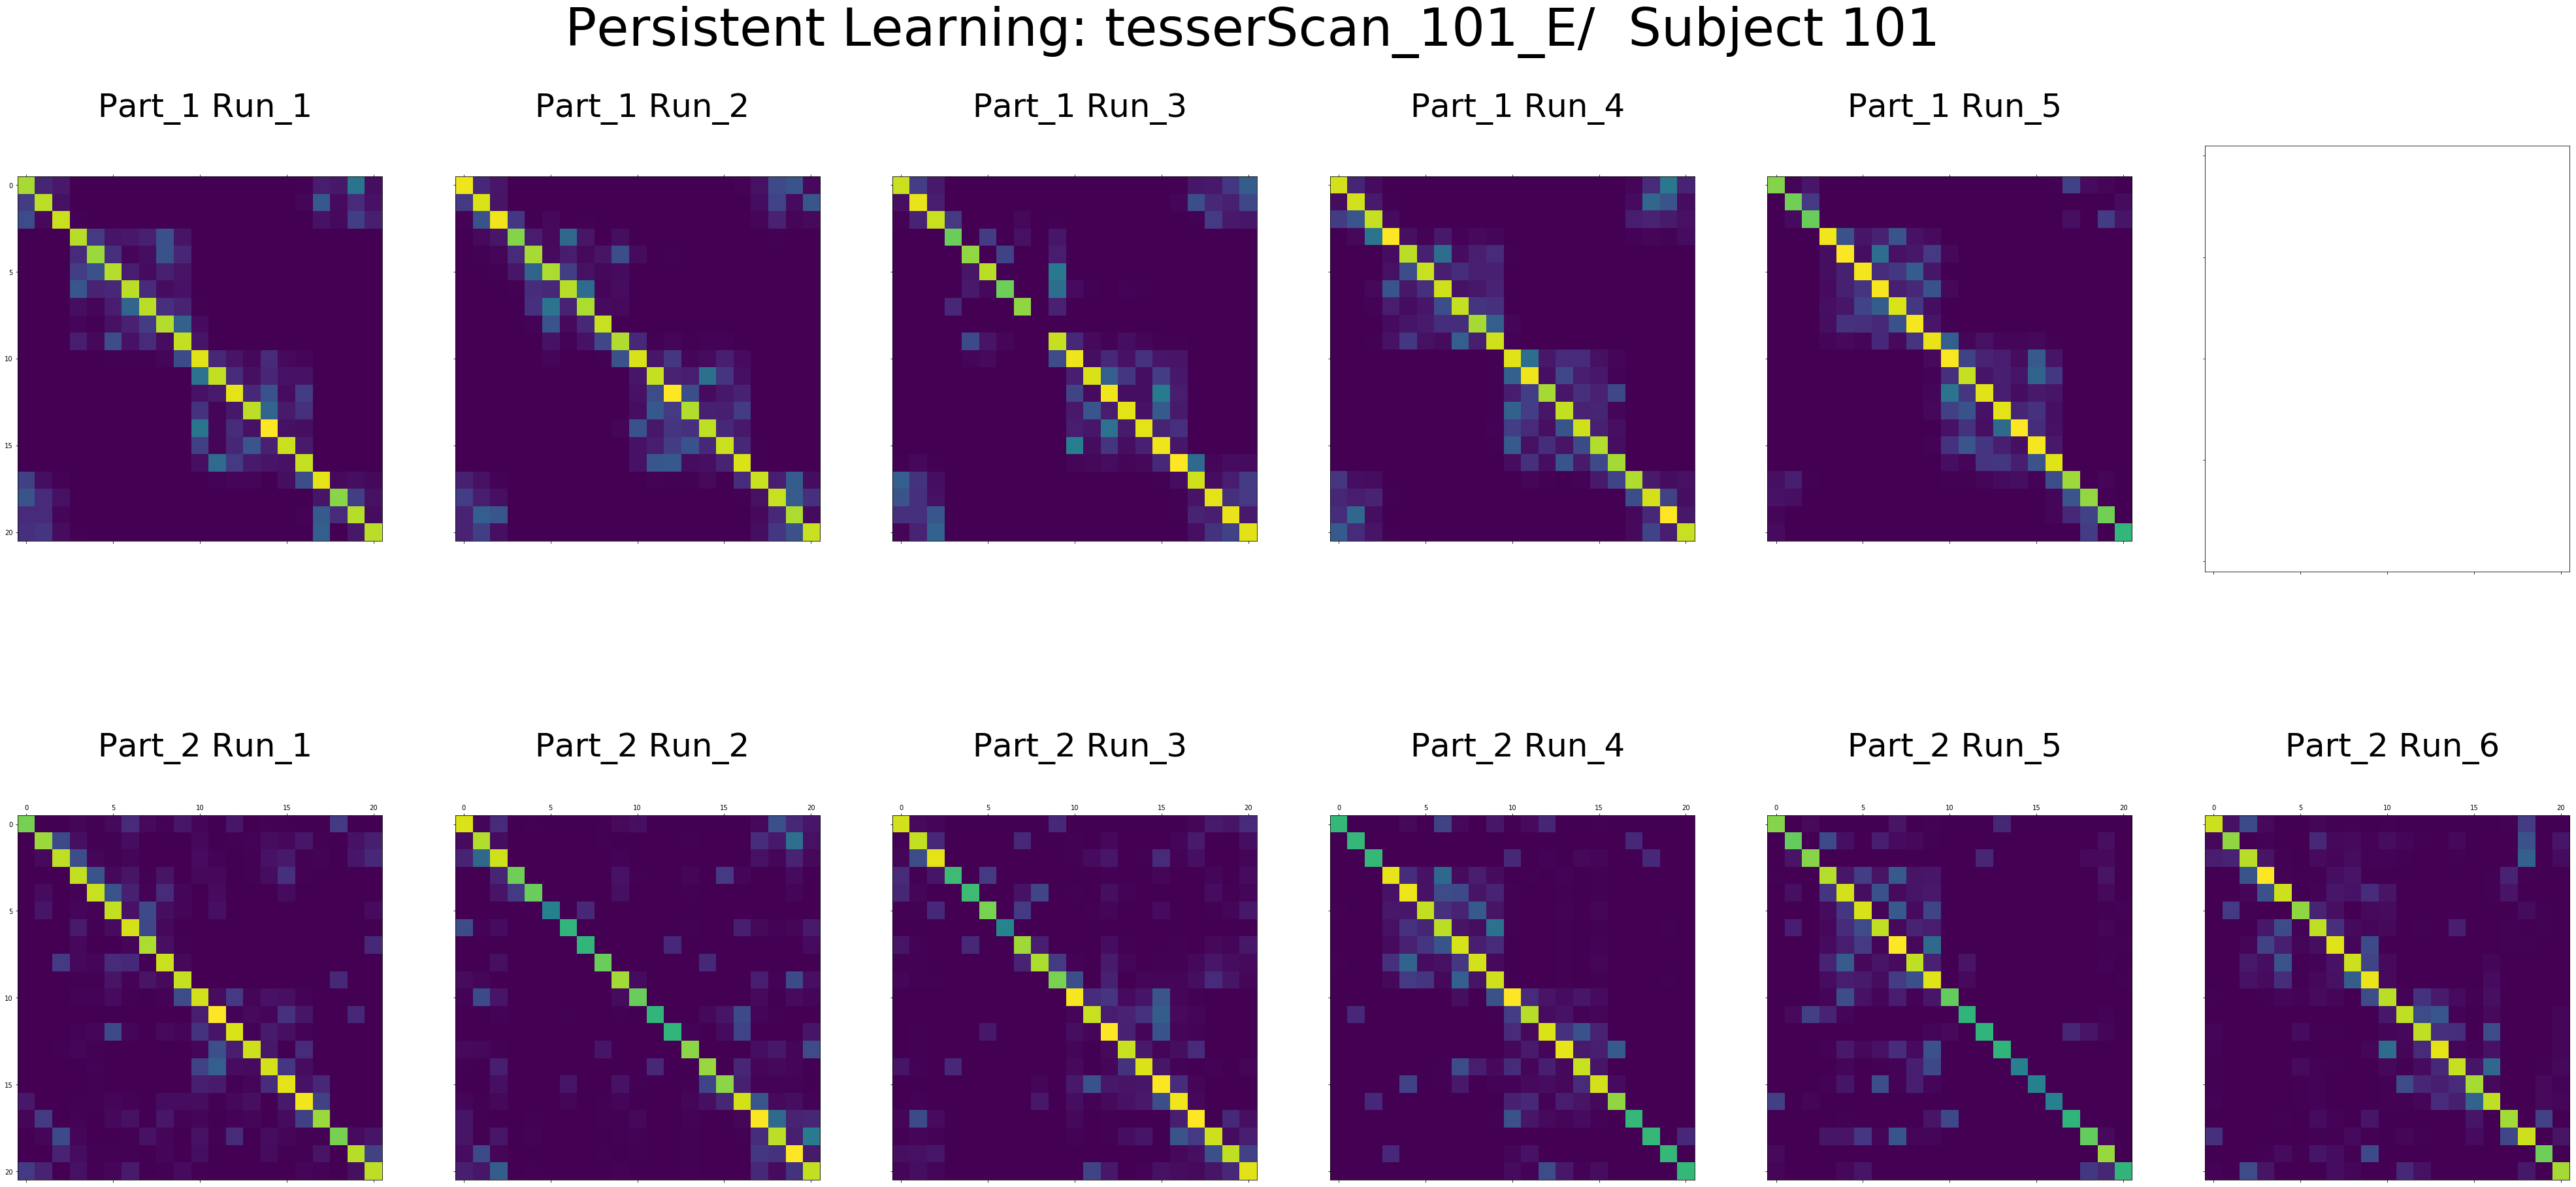

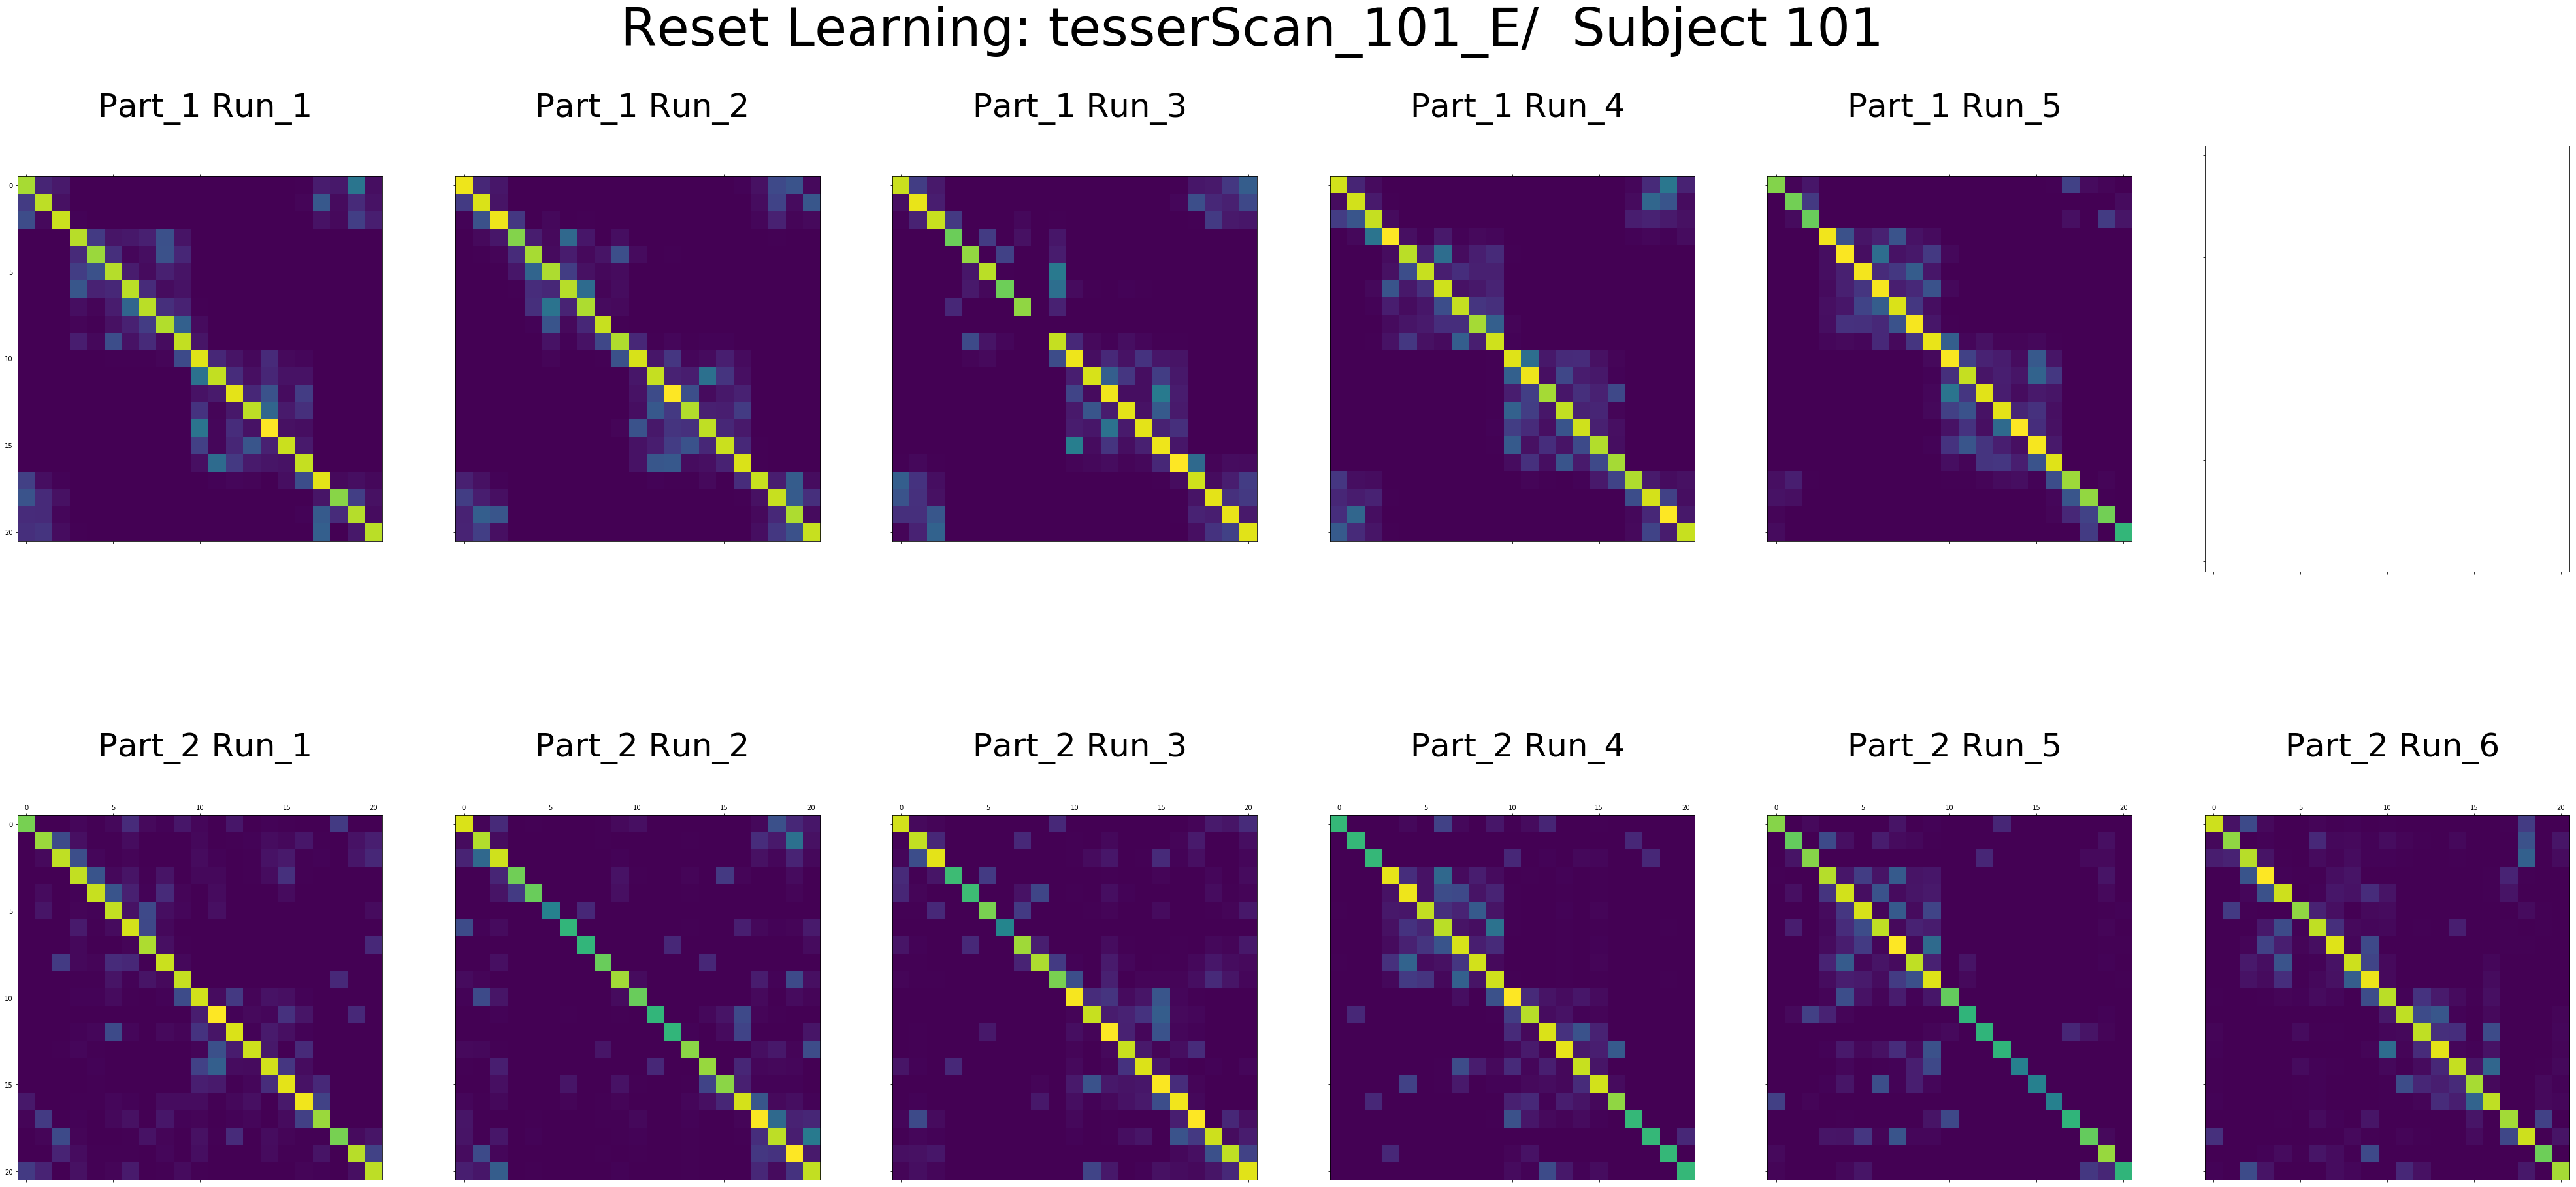

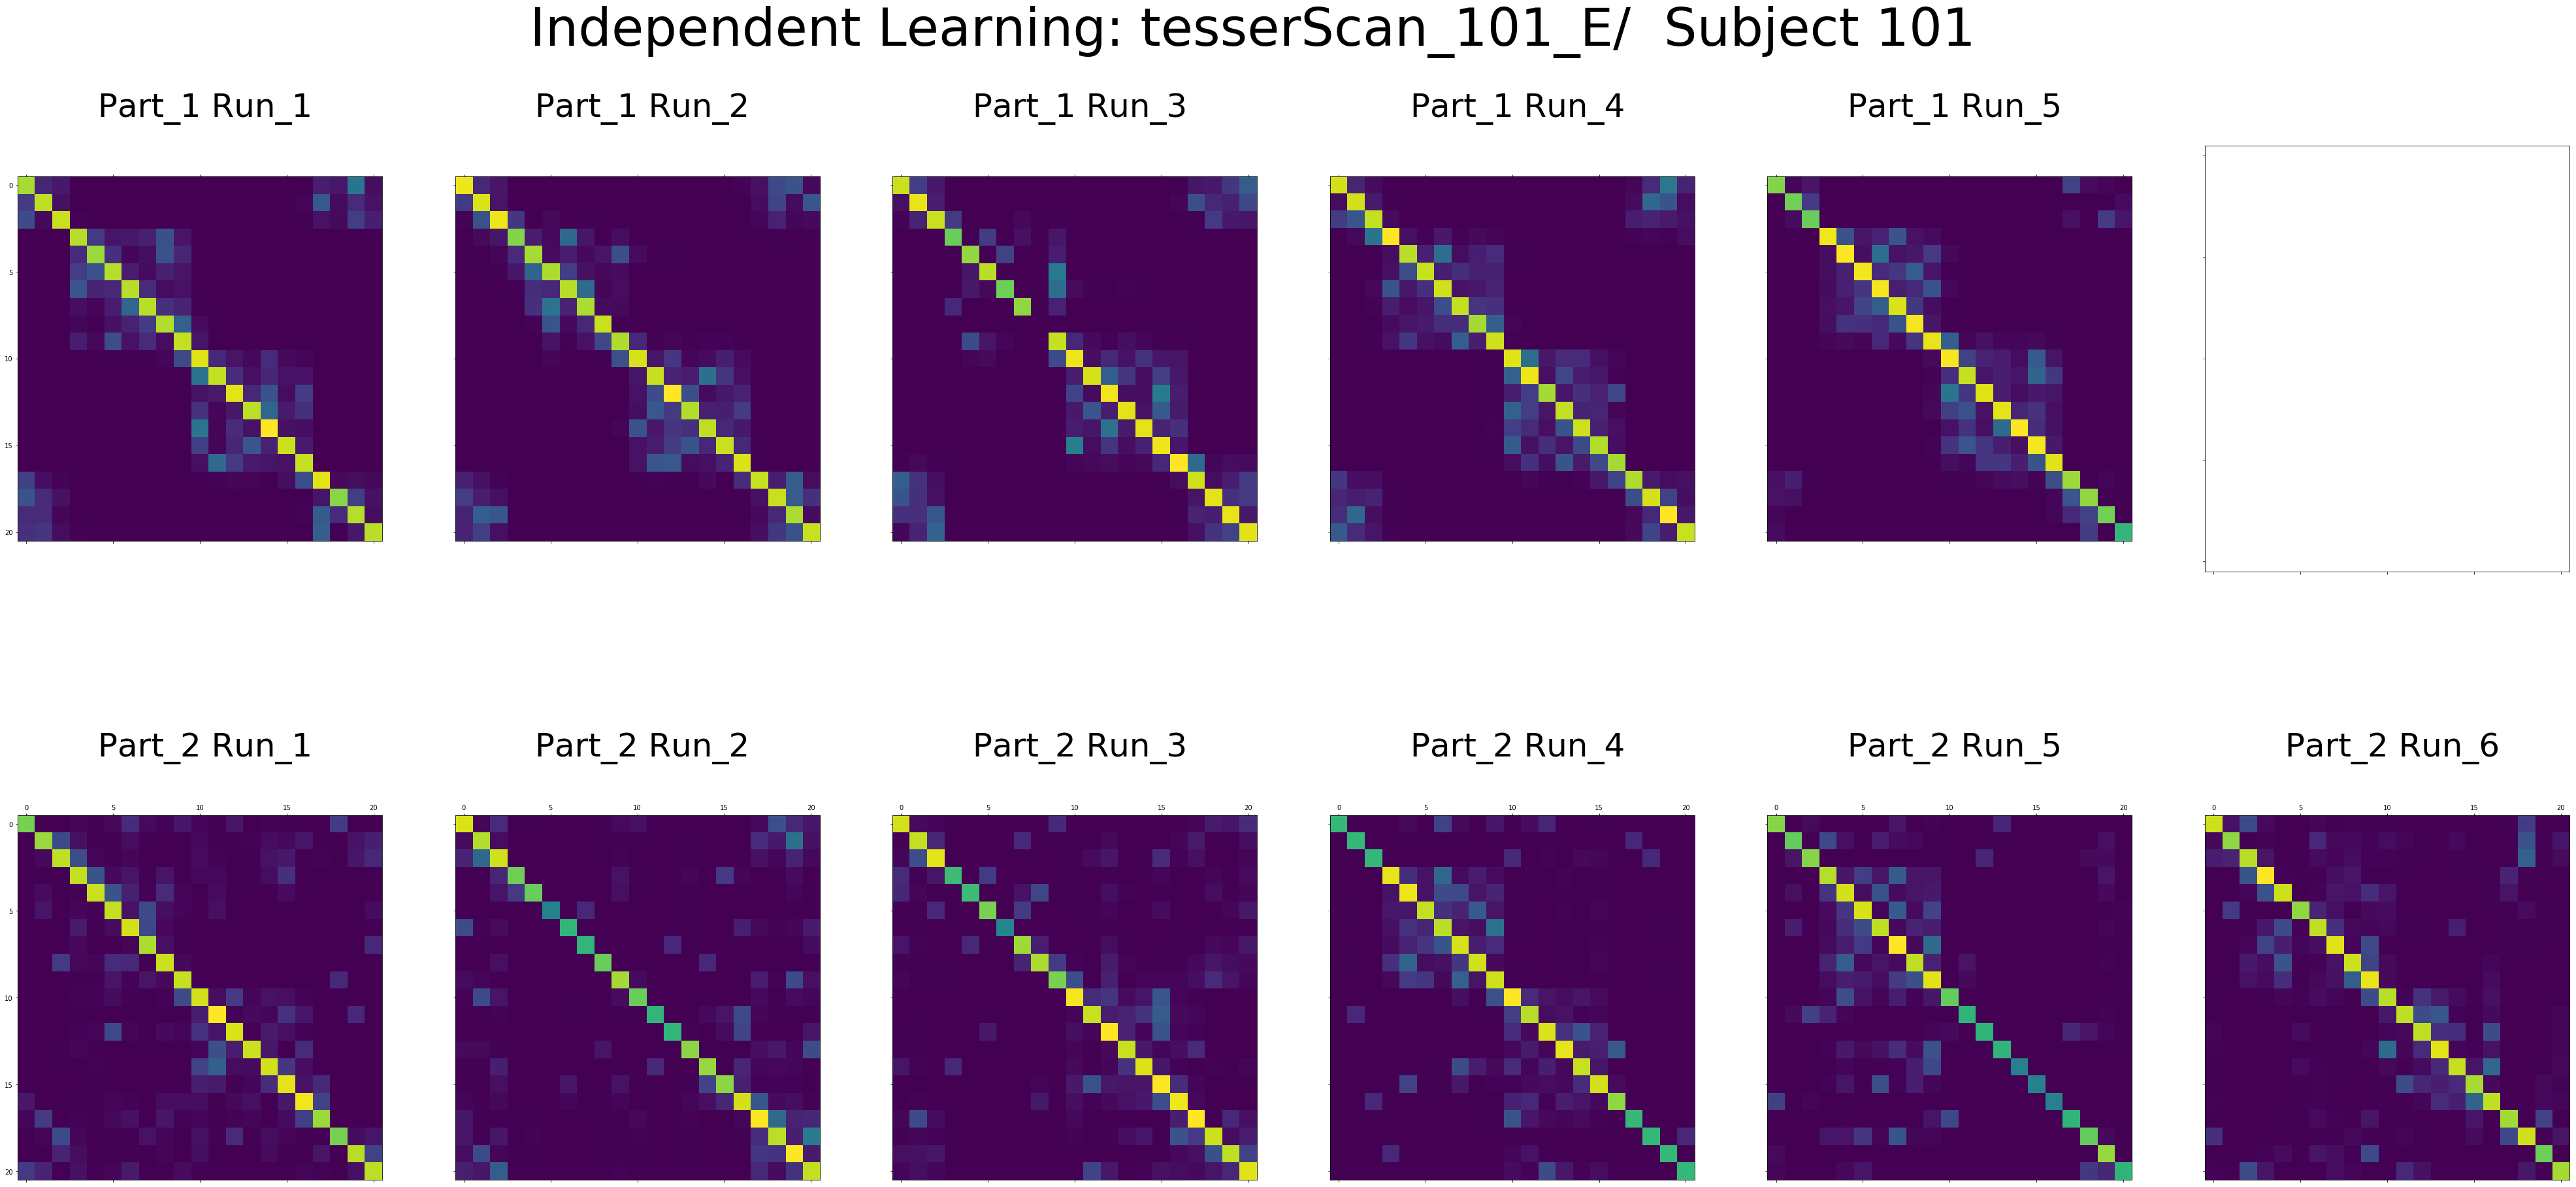

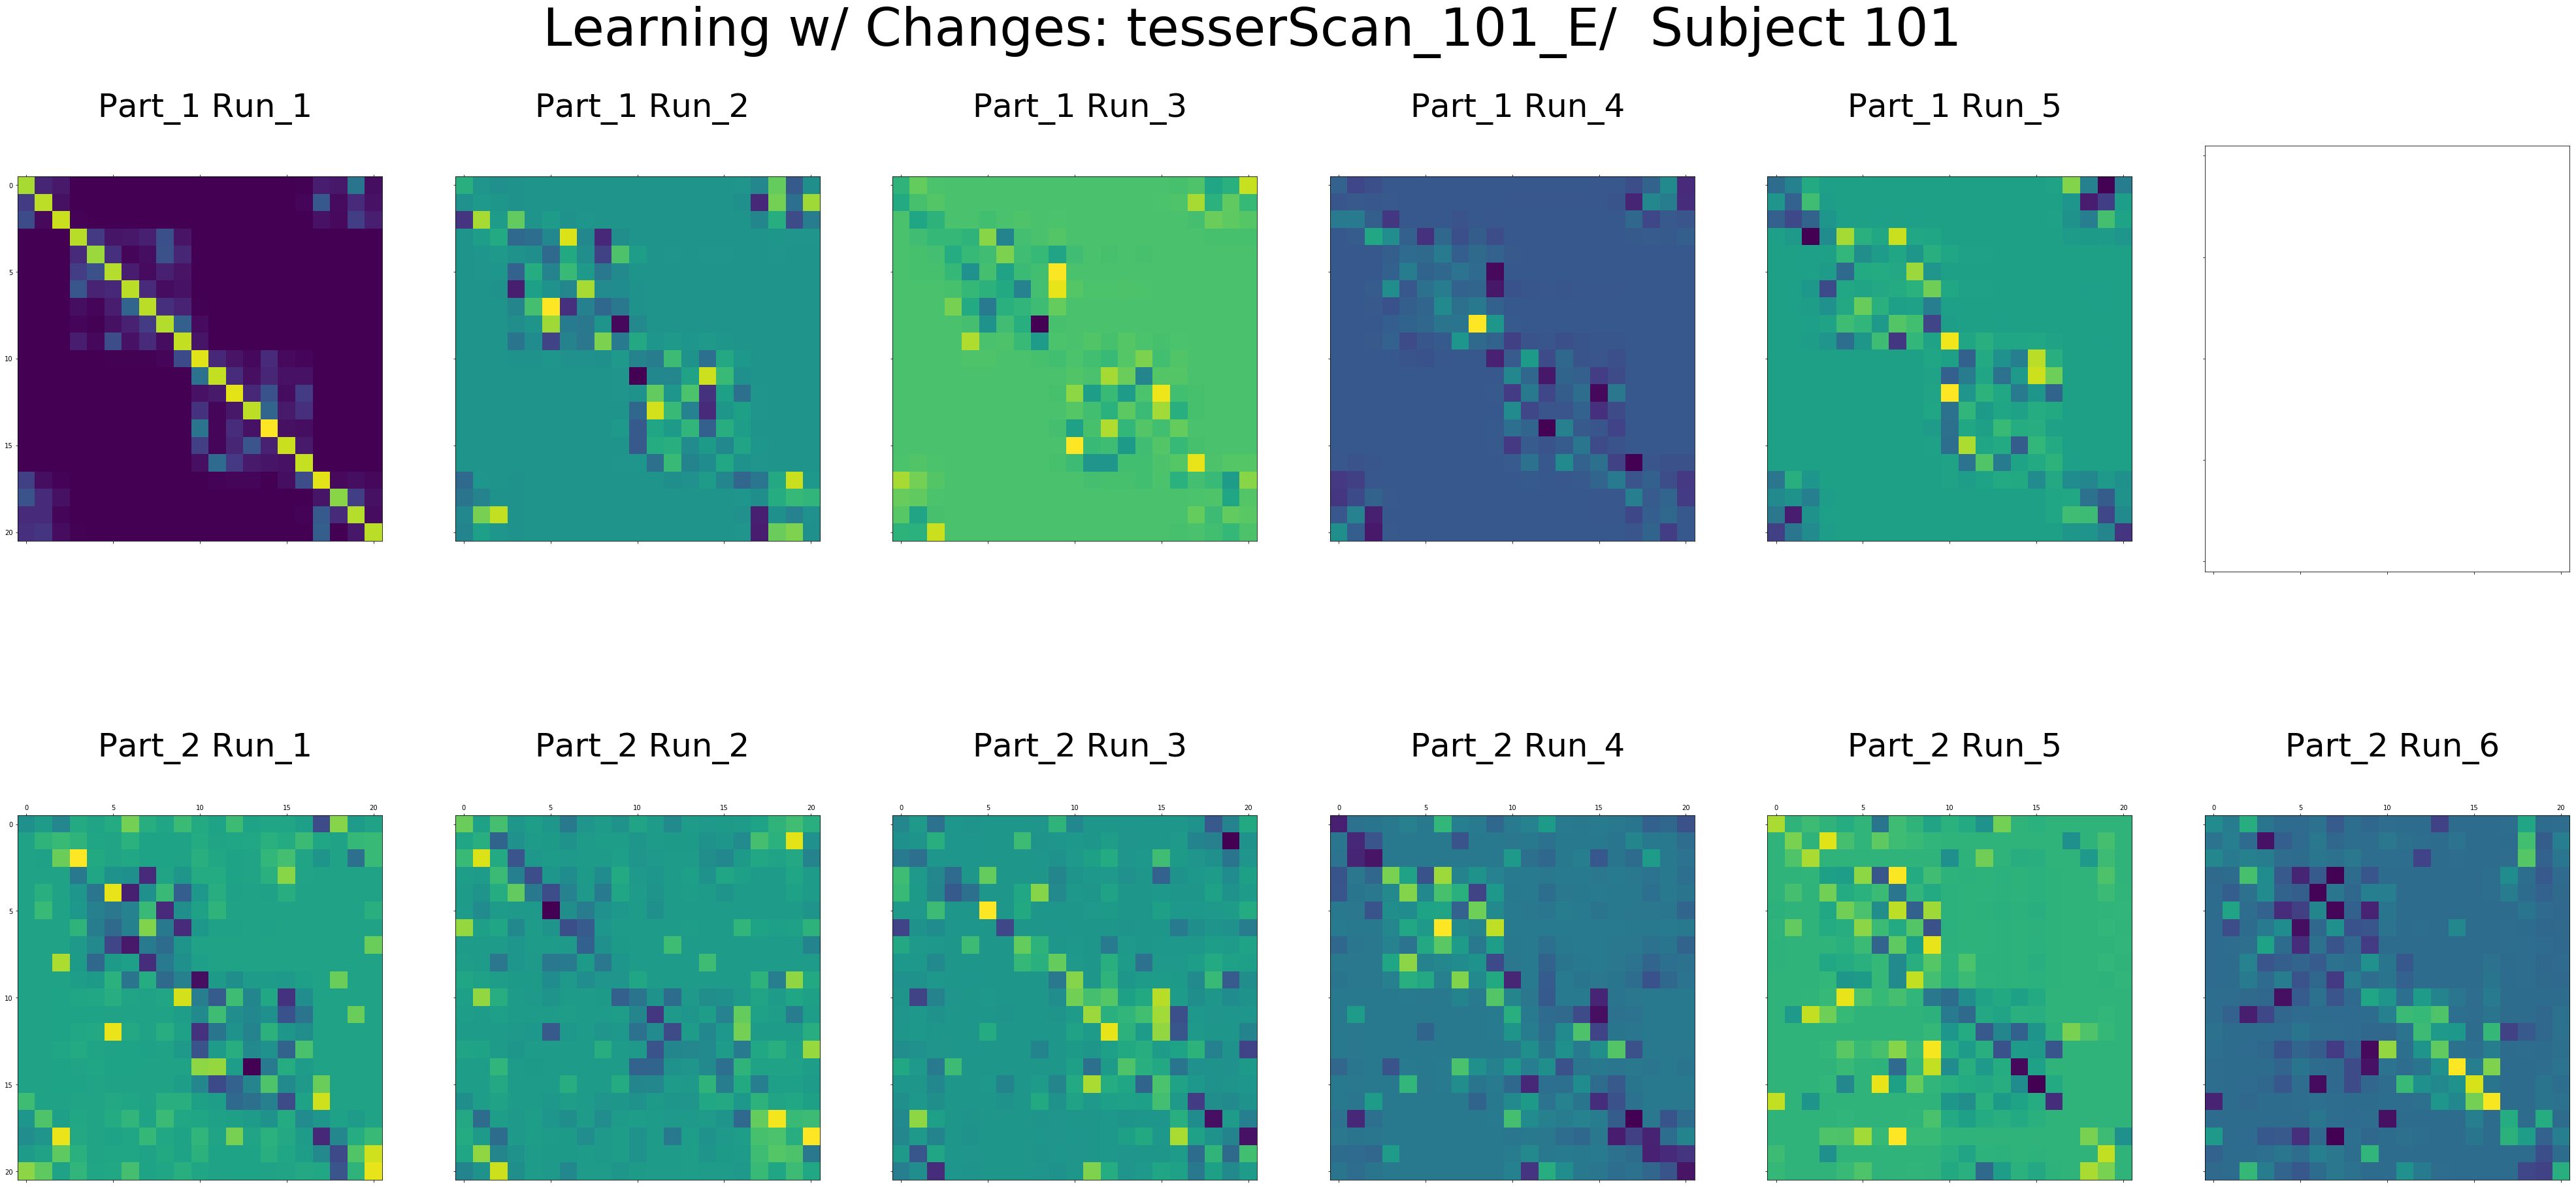

In [15]:
indiv(1)